In [1]:
use_real_data = True
blinded_fit = True

category = ['low', 'mid', 'high', 'single'][2]
useMVA = [False, 'v0', 'v1'][0]
schemeFF = ['CLN', 'BLPR', 'NoFF'][0]
card_name = 'noB0pTbothCv16'

In [2]:
useMCstats = True

runCombine = True
runScanOnly = False
runBias = False
runFitDiagnostics = True
runImpacts = False
runGoF = False

# Import

In [3]:
import sys, os, pickle, time
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories as categoriesDef
import itertools
import commands
from prettytable import PrettyTable
import json, yaml
from IPython.display import IFrame, Image, display

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleCategory, getControlXtitle, getControlSideText
from progressBar import ProgressBar
from lumi_utilities import getLumiByTrigger
from combine_utilities import getUncertaintyFromLimitTree, dumpDiffNuisances, stringJubCustomizationCaltechT2, loadHisto4CombineFromRoot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if use_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [5]:
card_name += category + '_' + schemeFF
if useMVA:
    card_name += '_MVA'+useMVA
if not use_real_data: 
    card_name += '_Asimov'
if blinded_fit: 
    card_name += '_blinded'
if not useMCstats: 
    card_name += '_NoMCstats'
outdir = 'results/' + card_name
if not os.path.isdir(outdir):
    os.system('mkdir -p ' + outdir + '/fig')
card_location = 'cards/{}.txt'.format(card_name)
histo_file_dir = '/storage/user/ocerri/BPhysics/data/_root/histos4combine/'

In [6]:
cat = categoriesDef[category]
binning = {'q2': array('d', [-2, 2.5, 6, 9.4, 12])}
SM_RDst = 0.295
expectedLumi = {'low':6.4, 'mid':20.7, 'high':26.4, 'single':6.} #fb^-1
lumi_tot = expectedLumi[category]

In [7]:
FreeParFF = {
   'CLN': ['R0', 'eig1', 'eig2', 'eig3'],
   'BLPR': ['eig1', 'eig2', 'eig3', 'eig4', 'eig5', 'eig6'],
   'NoFF': []
}[schemeFF]

# Create histograms

## Load the datasets

In [8]:
#They all have to be produced with the same pileup
MCsample = {
'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
'DstmD0' : DSetLoader('B0_DstmD0_PUc0'),
'DstmDp' : DSetLoader('B0_DstmDp_PUc0'),
'DstmDsp' : DSetLoader('B0_DstmDsp_PUc0'),
'BpDstmHc' : DSetLoader('Bp_DstmHc_PUc0'),
'BmDstmHc' : DSetLoader('Bm_DstmHc_PUc0'),
'antiB0DstmHc' : DSetLoader('antiB0_DstmHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
# 'DstPipPi0' : DSetLoader('Bp_MuNuDstPipPi0_PUc0'),
# 'DstPipPim' : DSetLoader('B0_MuNuDstPipPim_PUc0'),
'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
'TauDstPi0' : DSetLoader('B0_TauNuDstst_Pi0_PUc0'),
'TauDstPip' : DSetLoader('Bp_TauNuDstst_Pip_PUc0')
}
processOrder = ['tau', 'mu', 
                'DstPip','DstPi0',
                'DstPipPi0','DstPipPim','DstPi0Pi0',
                'TauDstPi0', 'TauDstPip',
                'DstmDsp','DstmD0','DstmDp',
                'BpDstmHc','BmDstmHc','antiB0DstmHc']
dSet = {}
dSetTkSide = {}
for n, s in MCsample.iteritems():
    if not n in processOrder: raise
    dSet[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name)))
#     dSet[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_bare.root'.format(cat.name)))

In [9]:
SamplesB0 = ['mu', 'tau', 
             'DstmD0', 'DstmDp', 'DstmDsp', 
             'antiB0DstmHc', 
             'DstPi0', 
             'DstPipPim', 'DstPi0Pi0', 
             'TauDstPi0'
            ]

SamplesBp = ['Bp_DstmHc_PUc0', 'Bm_DstmHc_PUc0', 
             'Bp_MuNuDstst_Pip_PUc0', 
             'Bp_MuNuDstst_PipPi0_PUc0', 
             'Bp_TauNuDstst_Pip_PUc0'
            ]

In [10]:
if use_real_data:
    creation_date = '201101'
    locRD = '../data/cmsRD/skimmed/B2DstMu_B0_{}_{}'.format(creation_date, cat.name)
    dSet['data'] = pd.DataFrame(rtnp.root2array(locRD + '_corr.root'))
    dataDir = '../data/cmsRD'
    datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_{}_CAND.root'.format(creation_date))
    lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
    if lumi_tot == 0:
        lumi_tot = {'Low':6.4, 'Mid':20., 'High':26.}[cat.name]
        print lumi_tot
    CMS_lumi.integrated_lumi = lumi_tot
    
    #Add anti-B0 data
    creation_date = '201122'
    locRD = '../data/cmsRD/skimmed/B2DstMu_antiB0_{}_{}'.format(creation_date, cat.name)
    aux = pd.DataFrame(rtnp.root2array(locRD + '_corr.root'))
    dSet['data'] = pd.concat([dSet['data'], aux])

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu12_IP6_part2_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu12_IP6_part1_v2 5.3
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu12_IP6_part4_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu12_IP6_part3_v2 5.29
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_201101
HLT_Mu12_IP6_part0_v2 5.25
Total lumi: 26.42 fb^-1


/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-ipykernel/4.8.2-gnimlf2/lib/python2.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



## Load calibrations

Pileup

In [11]:
from pileup_utilities import pileupReweighter
puReweighter = pileupReweighter(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), cat)

Branching fraction

In [12]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

Trigger scale factor

In [13]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF_v3.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

In [14]:
def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.zeros_like(ds['q2'])
    ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
    ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
    etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
    x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta, ip) in enumerate(x):
        ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
        iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
        iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
        trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
        ib = hTriggerSF.GetBin(ix, iy, iz)
        trgSFUnc[i] = hTriggerSF.GetBinError(ib)
        if trgSF[i] == 0:
            print pt, ip, np.abs(eta)
            raise
    # Divide them for the weight so later you can simply multiply back to get the value
    up = 1 + trgSFUnc/trgSF
    down = 1 - trgSFUnc/trgSF
    return trgSF, up, down

Muon ID scale factors

In [15]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

In [16]:
def computeMuonIDSF(ds, selection=None):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.zeros_like(ds['q2'])
    ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
    etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
    x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
    if not selection is None:
        x = x[selection]
    for i, (pt, eta) in enumerate(x):
        ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
        if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
        iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
        muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
        muonSFUnc[i] = hMuonIDSF.GetBinError(hMuonIDSF.GetBin(ix, iy))
        if muonSF[i] == 0:
            print pt, eta
            print ix, iy
            raise
    up = 1 + muonSFUnc/muonSF
    down = 1 - muonSFUnc/muonSF
#     print np.column_stack((muonSF, up, down, muonSF*up, muonSF*down))
#     raise
    return muonSF, up, down

B transverse momentum calibration

In [17]:
aux = 'Low' if category == 'single' else cat.name
cal_pT_B0 = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/polyCoeffWeights_{}.pkl'.format(aux))
cal_pT_Bp = pTCalReader(calibration_file='../data/calibration/Bcharged_pTspectrum/pwWeights_{}.txt'.format(aux))
# cal_pT_mu = pTCalReader(calibration_file='../data/calibration/MuonPtSpectrum/polyCoeffWeights_{}.pkl'.format(aux))

In [18]:
def computePtWeights(ds, var, tag, cal_pT):
    if cal_pT.kind == 'poly':
        # The denominator (sum of weights) for this weights is not known but it cancel out in the ratio
        w = cal_pT.getWeights(ds[var], shape=0)
        if np.sum(w==0):
            print np.sum(w==0)
            raise

        varDic = {}
        for iShape in range(1, cal_pT.nVar+1):
            varDic[tag+'_lam{}Down'.format(iShape)] = cal_pT.getWeights(ds[var], shape=-iShape)/w
            varDic[tag+'_lam{}Up'.format(iShape)] = cal_pT.getWeights(ds[var], shape=+iShape)/w
        return w, varDic
    elif cal_pT.kind == 'ratio':
        w = cal_pT.f['C'](ds[var])
        if np.sum(w==0):
            print np.sum(w==0)
            raise
        up = cal_pT.f['Up'](ds[var])/w
        down = cal_pT.f['Down'](ds[var])/w
        return w, up, down
    else:
        print 'Unknown calibration'
        raise

In [19]:
pWeightsEta = pickle.load(open('../data/calibration/B0pTspectrum/etaWeights_poly_{}.p'.format(cat.name), 'rb'))
def computeB0etaWeights(ds):
    w = np.polyval(p=pWeightsEta, x=ds['B_eta'])
    return np.clip(w, a_min=0.5, a_max=1.5)

In [20]:
def computeBrVarWeights(ds, selItems={}, relScale=0.2, keepNorm=False):
    sel = np.ones_like(ds['mu_pt']).astype(np.bool)
    for var, val in selItems.iteritems():
        sel = np.logical_and(ds[var].astype(np.int) == val, sel)
    w = np.ones_like(sel)
    up = np.where(sel, 1.+relScale, 1.)
    down = np.where(sel, max(0, 1.-relScale), 1.)
    if keepNorm:
        up = float(up.shape[0])/np.sum(up)
        down = float(down.shape[0])/np.sum(down)
    return w, up, down

In [21]:
def computeWidthVarWeights(ds, selItems=[], #pdgId, mass, Gamma
                           relScale=0.1): #Gamma modification factor
    up = np.ones_like(ds['mu_pt'])
    down = np.ones_like(ds['mu_pt'])
    for pdgId, mass, gamma in selItems:
        print pdgId, mass, gamma
        gUp = gamma*(1+relScale)
        gDown = gamma*(1-relScale)

        dx2 = np.clip(np.square(ds['MC_MassCharmedBDaughter'] - mass), 0, 9*(gamma**2))
        wUp = ((dx2 + gamma**2)*gUp)/(gamma*(dx2 + gUp**2))
        wDown = ((dx2 + gamma**2)*gDown)/(gamma*(dx2 + gDown**2))
        
        sel = np.abs(ds['MC_DstMotherPdgId'].astype(np.int)) == np.abs(pdgId)
        up = np.where(sel, wUp, up)
        down = np.where(sel, wDown, down)
        
    w = np.ones_like(sel)    
    return w, up, down

In [22]:
def computeTksPVweights(ds, relScale=0.05, centralVal=0.39/0.10):
    selPdgID0 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_0']) < 6, ds['MC_tkMotherPdgId_0'] != 0)
    selPdgID0 = np.logical_or(selPdgID0, ds['MC_tkMotherPdgId_0']==2212)
    selPdgID0 = np.logical_and(selPdgID0, ds['MC_tkFlag_0'] == 1)
    selPdgID1 = np.logical_and(np.abs(ds['MC_tkMotherPdgId_1']) < 6, ds['MC_tkMotherPdgId_1'] != 0)
    selPdgID1 = np.logical_or(selPdgID1, ds['MC_tkMotherPdgId_1']==2212)
    selPdgID1 = np.logical_and( selPdgID1, ds['MC_tkFlag_1'] == 1)
    exponent = selPdgID0.astype(np.int) + selPdgID1.astype(np.int)
    w = np.power(centralVal, exponent)
    up = np.power(centralVal*(1+relScale), exponent)/w
    down = np.power(centralVal*(1-relScale), exponent)/w
    return w, up, down

MVA

In [23]:
if useMVA:
    fname = '../plot_scripts/kinObsMVA/clfGBC_tauVall_{}{}.p'.format(useMVA, cat.name)
    clfGBC = pickle.load(open(fname, 'rb'))
    
    def computeVarMVA(ds):
        if useMVA == 'v0':
            aux = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss']))
        elif useMVA == 'v1':
            ds['pt_vis'] = ds['B_pt']*ds['mass_D0pismu']/5.27963
            aux = np.column_stack((ds['q2'], ds['Est_mu'], ds['M2_miss'], 
                                   ds['pt_vis'], ds['mass_D0pismu'],
                                   ds['B_eta']
                                         ))
        else: raise
        p = clfGBC.predict_proba(aux)
        return p[:,1]

## Create MC histograms

In [24]:
histo = {}
eventCountingStr = {}
RDoMC_normRatio = 6 # Difference in Pythia prediction between Hard and Soft QCD production
RDoMC_normRatio *= 2 #Both charge signs

### Signal region

In [25]:
binning = {
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, -0.2, 0.4)) + [-0.2, 0., 0.2, 0.6, 8] ),
        array('d', [-2.5] + list(np.arange(-1.8, -0.1, 0.4)) + [-0.1, 0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.0, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.6, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
    ],
    'Est_mu'  : [
        array('d', [0.3] + list(np.arange(0.5, 2.4, 0.05)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.05)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.1)) + [2.5] ),
        [22, 0.3, 2.500],
    ],
}

binning_2D = [
    [
        array('d', [-2.5] + list(np.arange(-1.8, -0.2, 0.4)) + [-0.2, 0., 0.2, 0.6, 8] ),
#         array('d', [0.3] + list(np.arange(0.7, 2.3, 0.5)) + [2.5] )
        array('d', [0.3] + list(np.arange(0.7, 2.3, 0.3)) + [2.5] )
    ],
    [
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.4)) + [8] ),
#         array('d', [0.3] + list(np.arange(0.7, 2.5, 0.5)) + [2.5] )
        array('d', [0.3] + list(np.arange(0.7, 2.5, 0.3)) + [2.5] )
    ],
    [
        array('d', [-2.5] + list(np.arange(-1.8, 5.6, 0.4)) + [8] ),
        array('d', [0.3] + list(np.arange(0.5, 2.5, 0.3)) + [2.5] )
    ],
    [
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
        array('d', list(np.linspace(0.3, 2.5, 11)) )
    ]
    
]

binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])
binning['B_pt'] = {'low': array('d', list(np.arange(11, 75, 2)) ),
                   'mid': array('d', list(np.arange(14, 90, 2)) ),
                   'high': array('d', list(np.arange(18, 110, 2)))
                  }[category]

binning['mu_pt'] = 4*[{'low': array('d', list(np.arange(7, 9, 0.05))+[9] ),
                   'mid': array('d', list(np.arange(9, 12, 0.05)) +[12] ),
                   'high': array('d', list(np.arange(12, 20, 0.1)))
                  }[category]]

binning['Dst_pt'] = array('d', list(np.arange(5, 30, 1)) )

binning['B_eta'] = array('d', list(np.arange(-1.7, 1.71, 0.05)) )

if use_real_data:
    binning['MVA'] = array('d', list(np.arange(0., 0.51, 0.03)))
else:
    binning['MVA'] = array('d', list(np.arange(0., 0.83, 0.02)))

In [26]:
totalCounting = [0,0]
for n in processOrder: 
    ds = dSet[n]
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    totalCounting[1] += 1e-3*nTotSelected
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.2f}k'.format(1e-3*nTotExp)
    
    wVar = {}
    weights = {}
    
    print 'Including pileup reweighting'
    weights['pileup'] = puReweighter.weightsPileupMC[ds['N_vtx'].astype(np.int)]
    print 'Including trigger corrections'
    weights['trg{}SF'.format(cat.trg)], _, _ = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], _, _ = computeMuonIDSF(ds)
    weights['etaB'] = computeB0etaWeights(ds)
#     weights['MuPt'], _ = computePtWeights(ds, 'mu_pt', 'MuPt', cal_pT_mu)
    print 'Including B0 pT corrections'
    if n in SamplesB0:
        print 'Including B0 pT corrections'
        weights['B0pT'], _ = computePtWeights(ds, 'MC_B_pt', 'B0pT', cal_pT_B0)
    if n in SamplesBp:
        print 'Including B +/- pT corrections'
        weights['BpPt'], _, _ = computePtWeights(ds, 'MC_B_pt', None, cal_pT_Bp)
    # Hammer corrections to the FF
    if n in ['mu', 'tau'] and schemeFF != 'NoFF':
        print 'Including FF corrections (Hammer)'
        weights['B2DstFF'] = ds['wh_'+schemeFF+'Central']*sMC.effCand['rate_den']/sMC.effCand['rate_'+schemeFF+'Central']
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): 
        weightsCentral *= w
    print 'N tot expected (after weights): {:.3f}k'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected)
    totalCounting[0] += 1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected
    evCountStr = '{:.2f} ({:.2f})'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected, 1e-3*nTotSelected)
    eventCountingStr[n] = evCountStr
    wVar[''] = np.ones_like(weightsCentral)
    
    
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] <= q2_h)

        for var in ['M2_miss', 'Est_mu', 'mu_pt']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            if not cat_name in histo.keys():
                histo[cat_name] = {}
            
            for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo[cat_name][h_name] = create_TH1D(
                                                      ds[var][sel_q2], 
                                                      name=h_name, title=h_name, 
                                                      binning=binning[var][i_q2], 
                                                      opt='underflow,overflow',
                                                      weights=w[sel_q2], scale_histo=scale,
                                                      )

                
    for var in ['B_pt', 'B_eta', 'Dst_pt']:
        if not var in histo.keys():
            histo[var] = {}          
        for name_wVar, v_wVar in wVar.iteritems():
            h_name = n
            if not name_wVar == '':
                h_name += '__' + name_wVar
            w = weightsCentral*v_wVar
            scale = nTotExp/nTotSelected
            histo[var][h_name] = create_TH1D(ds[var], name=h_name, weights=w, scale_histo=scale,
                                                binning=binning[var], opt='underflow,overflow')
                
                
evCountStr = '{:.1f} ({:.1f})'.format(*totalCounting)
eventCountingStr['tot'] = evCountStr


-----------> tau <-------------
N tot selected: 31.4k
N tot expected (before weights): 58.92k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 63.413k

-----------> mu <-------------
N tot selected: 834.1k
N tot expected (before weights): 998.28k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Including B0 pT corrections
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 1022.064k

-----------> DstPip <-------------
N tot selected: 18.8k
N tot expected (before weights): 19.42k
Including pileup reweighting
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Computing total weights
N tot expected (after weights): 20.148k

-----------> DstPi0 <-------------
N tot 

## Create (pseudo-)data histogram

In [27]:
if use_real_data:
    ds = dSet['data']
    print 'N observed data signal region: {:.1f}k'.format(1e-3*ds['q2'].shape[0])
                
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu', 'mu_pt']:
            cat_name = var+'_q2bin'+str(i_q2)     
            histo[cat_name]['data'] = create_TH1D(
                                                  ds[var][sel_q2], 
                                                  name='data_obs', title='Data Obs',
                                                  binning=binning[var][i_q2],
                                                  opt='underflow,overflow'
                                                 )
            
    for var in ['B_pt', 'B_eta', 'Dst_pt']:
        histo[var]['data'] = create_TH1D(ds[var], name='data_obs', binning=binning[var], opt='underflow,overflow')
        
        
if useMVA:
    h = create_TH1D(np.array([0, 0]), name='total', title='total', binning=binning['MVA'])
    h.Reset()
    for n, hMC in histo['MVA'].iteritems():
            if not '__' in n and not n == 'data':
                scale = SM_RDst if 'tau' in n else 1.
                h.Add(hMC, scale)
    h.Sumw2(0)
    for i in range(1, h.GetNbinsX()+1):
        h.SetBinContent(i, np.around(h.GetBinContent(i)))
    h.Sumw2()
    histo['MVA']['total'] = h
for i_q2 in range(len(binning['q2'])-1):
    for var in ['M2_miss', 'Est_mu', 'mu_pt']:
        cat_name = var+'_q2bin'+str(i_q2)

        h = histo[cat_name].values()[0].Clone('total')
        h.SetTitle('total')
        h.Reset()
        for n, hMC in histo[cat_name].iteritems():
            if not '__' in n and not n == 'data':
                scale = SM_RDst if 'tau' in n else 1.
                h.Add(hMC, scale)
        h.Sumw2(0)

        for ix in range(1, h.GetNbinsX()+1):
            if h.GetNbinsY() > 1:
                for iy in range(1, h.GetNbinsY()+1):
                    h.SetBinContent(ix, iy, np.around(h.GetBinContent(ix, iy)))
            else:
                h.SetBinContent(ix, np.around(h.GetBinContent(ix)))
        h.Sumw2()
        histo[cat_name]['total'] = h

for var in ['B_pt', 'B_eta', 'Dst_pt']:
    h = create_TH1D(np.array([0, 0]), name='total', title='total', binning=binning[var])
    h.Reset()
    for n, hMC in histo[var].iteritems():
            if not '__' in n and not n == 'data':
                scale = SM_RDst if 'tau' in n else 1.
                h.Add(hMC, scale)
    h.Sumw2(0)
    for i in range(1, h.GetNbinsX()+1):
        h.SetBinContent(i, np.around(h.GetBinContent(i)))
    h.Sumw2()
    histo[var]['total'] = h

N observed data signal region: 1340.4k


# Pre-fit plots

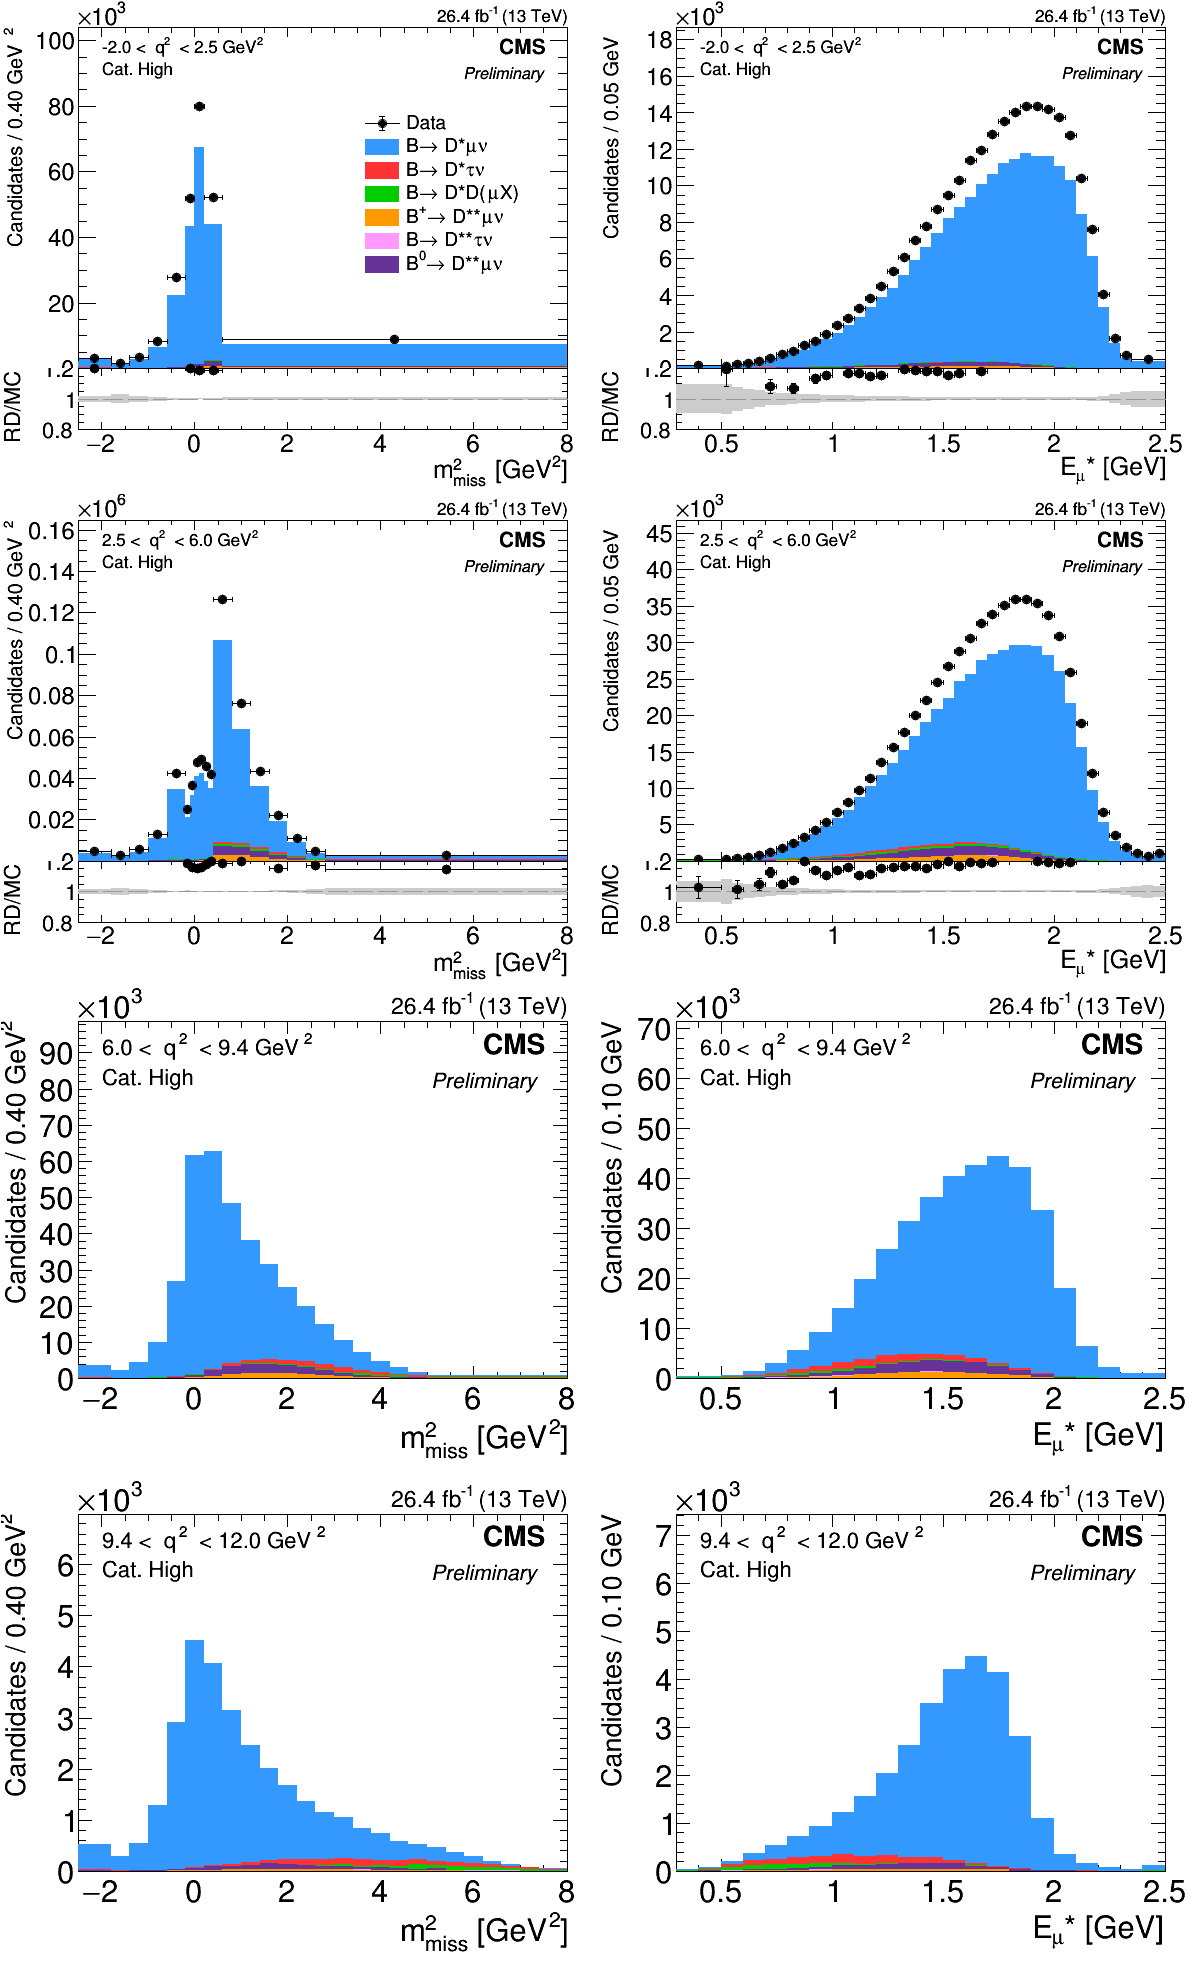

In [28]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {'tau': SM_RDst}

cSigPre = plot_gridVarQ2(CMS_lumi, binning, histo, draw_pulls=True, pullsRatio=True,
                         scale_dic=scale_dic, min_y=0, logy=False, 
                         categoryText=cat.name.capitalize(),
                         iq2_maskData=[2, 3] if blinded_fit else [])

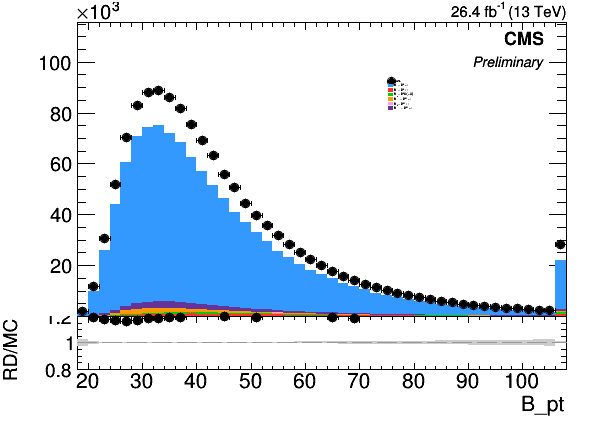

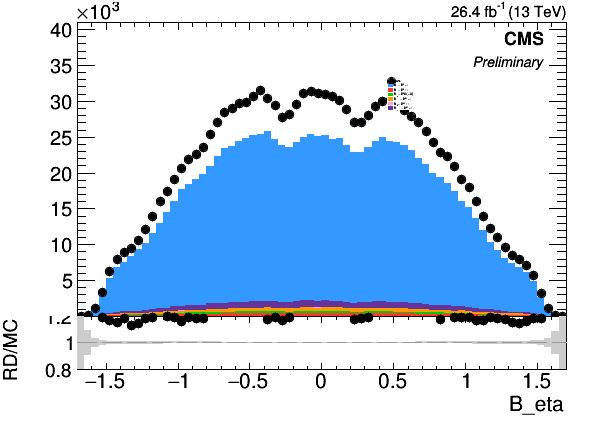

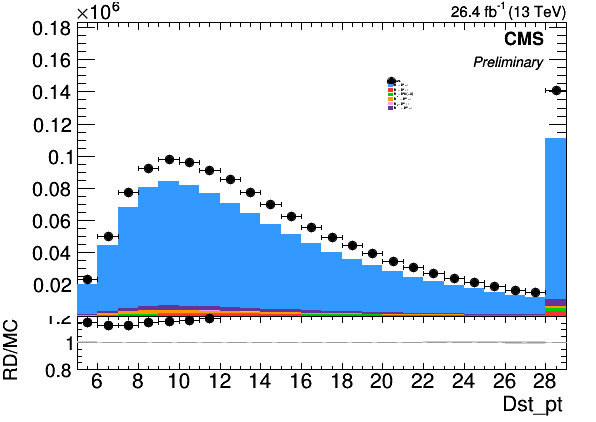

In [29]:
cBPre = {}
for k in ['B_pt', 'B_eta', 'Dst_pt']:
    histo[k]['data'].GetXaxis().SetTitle(k)
    cBPre[k] = plot_SingleCategory(CMS_lumi, histo[k], scale_dic=scale_dic, draw_pulls=True, pullsRatio=True,
                                   addText='', logy=False, legBkg=True,
                                   procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                   min_y=1, tag=k, legLoc=[0.65, 0.65, 0.7, 0.75])

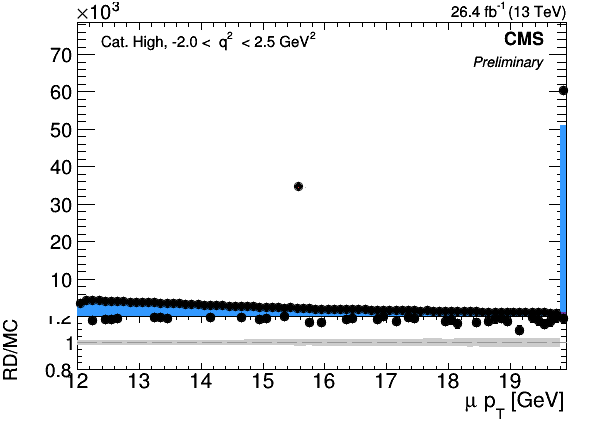

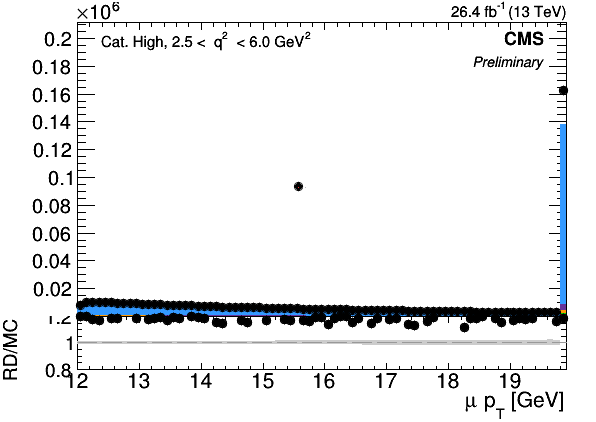

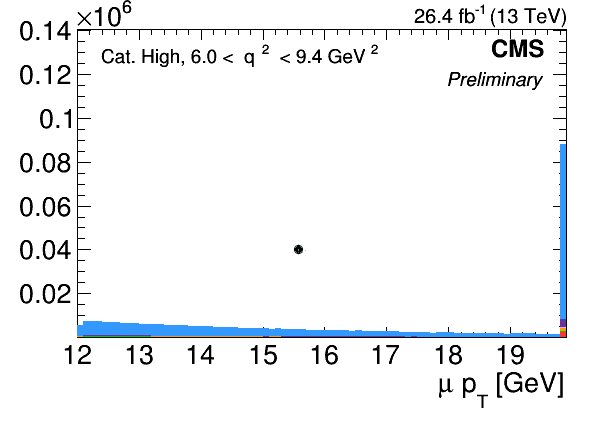

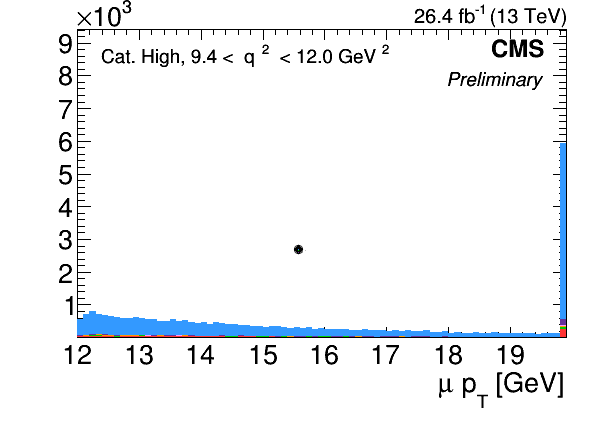

In [30]:
cUnrolledPre = []
for i_q2 in range(len(binning['q2'])-1):
    q2_l = binning['q2'][i_q2]
    q2_h = binning['q2'][i_q2 + 1]
    nameU = 'mu_pt_q2bin'+str(i_q2)
    histo[nameU]['data'].GetXaxis().SetTitle('#mu p_{T} [GeV]')
    histo[nameU]['data'].GetYaxis().SetTitle('Events')
    cUnrolledPre.append(plot_SingleCategory(CMS_lumi, histo[nameU], scale_dic=scale_dic, 
                                            draw_pulls=True, pullsRatio=True,
                                            addText='Cat. '+category.capitalize()+', {:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h), 
                                            logy=False, legBkg=True,
                                            procOrder = ['tau', 'DstD', 'Dstst', 'mu'],
                                            min_y=1, 
                                            tag='mu_pt_q2bin'+str(i_q2), 
                                            legLoc=[0.5, 0.4, 0.51, 0.41],
                                            maskData = blinded_fit and (False if i_q2 < 2 else True)
                                      ))

# Possible corrections

In [31]:
muPt = []
ratio = []
errRatio = []
for iq2 in [0,1]:
    name = 'mu_pt_q2bin'+str(iq2)
    hd = histo[name]
    nx = hd['total'].GetNbinsX()
    r = np.ones(nx)
    dr = np.ones(nx)
    pt = np.ones(nx)
    
    hRatio = hd['data'].Clone('hRatio')
    hRatio.Scale(hd['total'].Integral()/hRatio.Integral())
    hRatio.Divide(hd['total'])
    
    for ix in range(1, nx+1):
        r[ix-1] = hRatio.GetBinContent(ix)
        dr[ix-1] = hRatio.GetBinError(ix)
        pt[ix-1] = hRatio.GetBinCenter(ix)
    
    muPt.append(pt)
    ratio.append(r)
    errRatio.append(dr)


Chi2/dof = 142.65/156 (77.1%)


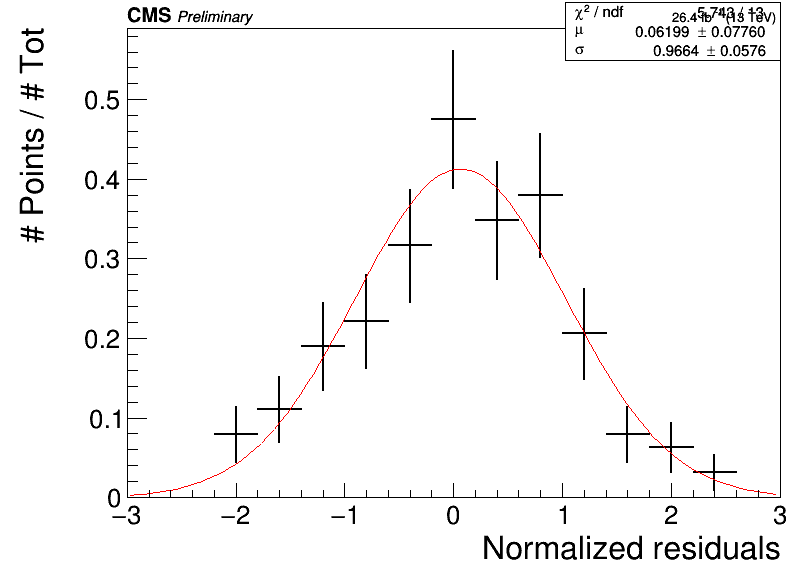

In [32]:
deg = 1
x = np.concatenate(muPt)
y = np.concatenate(ratio)
dy = np.concatenate(errRatio)
beta, covBeta = np.polyfit(x, y, deg=deg, full=False, w=1./dy, cov='unscaled')

res = (y - np.polyval(beta, x))/dy

chi2stat = np.sum(np.square(res))
dof = res.shape[0]-deg-1
pval = 1 - sps.chi2.cdf(chi2stat, df=dof)
print '\nChi2/dof = {:.2f}/{:.0f} ({:.1f}%)'.format(chi2stat, dof, 100*pval)

h = create_TH1D(res, binning=[15, -3,3],
                axis_title=['Normalized residuals', '# Points / # Tot'],
                scale_histo='norm'
               )
h.Scale(1./h.GetBinWidth(2))

fGaus = rt.TF1('fFit', 'exp(-(x-[0])*(x-[0])/(2*[1]*[1]))/({:.4f}*[1])'.format(np.sqrt(2*np.pi)), -5, 5)
fGaus.SetParameters(0,1)
fGaus.SetParNames('#mu','#sigma')
h.Fit(fGaus, 'QWL')
cResiduals = drawOnCMSCanvas(CMS_lumi, [h], ['E'], tag='residuals')

In [33]:
eigVal, eigVec = np.linalg.eig(covBeta)
eigSig = np.sqrt(eigVal)

print 'Beta:  '+', '.join(beta.shape[0]*['{:1.2e}']).format(*beta)
print 'Error: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*np.sqrt(np.diag(covBeta)))

betaVar = []
for i in range(eigSig.shape[0]):
    print '\n'
    betaVar.append(eigSig[i]*eigVec[:, i])
    print 'eigSigma: {:1.2e}'.format(eigSig[i])
    print 'eigVect: '+', '.join(beta.shape[0]*['{:.2f}']).format(*eigVec[:, i])
    print 'Variation: '+', '.join(beta.shape[0]*['{:1.2e}']).format(*betaVar[i])

Beta:  -1.48e-03, 1.02e+00
Error: 5.50e-04, 9.10e-03


eigSigma: 9.38e-05
eigVect: -1.00, -0.06
Variation: -9.37e-05, -5.58e-06


eigSigma: 9.11e-03
eigVect: 0.06, -1.00
Variation: 5.42e-04, -9.10e-03


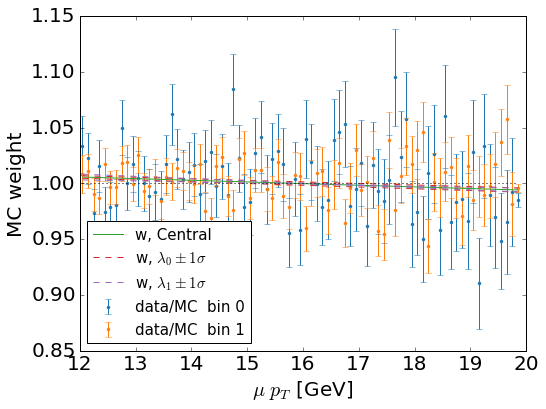

In [34]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(8,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.errorbar(muPt[0], ratio[0], yerr=errRatio[0], fmt='.', color=colors[0], label='data/MC  bin 0')
plt.errorbar(muPt[1], ratio[1], yerr=errRatio[1], fmt='.', color=colors[1], label='data/MC  bin 1')

plt.plot(muPt[0], np.polyval(beta, muPt[0]), '-', color=colors[2], label='w, Central')


for i in range(len(betaVar)):
    yP = np.polyval(beta+betaVar[i], muPt[0])
    yM = np.polyval(beta-betaVar[i], muPt[0])
    plt.plot(muPt[0], yP, '--', color=colors[i+3], label='w, $\lambda_{} \pm 1\sigma$'.format(i))
    plt.plot(muPt[0], yM, '--', color=colors[i+3])
    
plt.plot(muPt[0] , [1]*len(muPt[0]), ':k')
plt.legend(loc='best', numpoints=1, fontsize=15)
plt.xlabel('$\mu\ p_T$ [GeV]')
plt.ylabel('MC weight')
# _, ymax = plt.ylim()
# plt.xlim(0.95*np.min(muPt[0]), 1.05*np.max(muPt[0]))
# plt.text(0.9*np.max(muPt[0]) ,ymax*0.9, 'Category: ' + cat.name, horizontalalignment='right')

In [35]:
# dOut = {
#     'beta': beta,
#     'betaVar' : betaVar
# }

# pickle.dump(dOut, open('../data/calibration/MuonPtSpectrum/polyCoeffWeights_{}.pkl'.format(cat.name), 'wb'))